# 0. Initial set up
In this report, we will walk you through our learning process. At the same time, we will also include information about steps to run our code and visualize our results. 

First, please run the following code: 

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# I. Introduction
We used data made public for educational purposes by Yelp Inc.. To motivate students and researchers in their pursuits of developments of better algorithms and practices in tackling big and complex data, Yelp created public challenges by publishing a part of their data and  challeng scholars and curious minds to find meanings in their wealth of data. The data we downloaded from Yelp is 4.98GB; we used data from round 9 challenge. The link to the data is: https://www.yelp.com/dataset_challenge


## 1. Item-based collaborative filtering
Collaborative filtering is a recommender system technique that makes predictions about the interests of a user by collecting preferences or taste information (in our case, rating or number of stars a user gives a business) from many users. This can either be done by (1) computing similar users (user-based), or (2) computing similar items (item-based). Maintaining a user-user similarity matrix is more computationally expensive than an item-item similarity matrix, so we choose to the latter: in this case, we have 1,029,432 users and 144,072 businesses.

Similarity measures include Jaccard similarity, Cosine similarity and Pearson Correlation similarity. We choose to use Pearson Correlation similarity because our data has explicit ratings (while Jaccard is good for implicit rating case), and it also removes effects of means and variance (unlike Cosine). Source and more information can be found [here](https://turi.com/products/create/docs/generated/graphlab.recommender.item_similarity_recommender.ItemSimilarityRecommender.html#graphlab.recommender.item_similarity_recommender.ItemSimilarityRecommender).

Since item-based collaborative filtering is an established technique, we want to use it as a reference for comparison with our original method, and so we use a third library instead of trying to implement it ourselves. Our textbook recommends [Crab](https://github.com/muricoca/crab/issues) but we had trouble importing and using it, not to mention it has been abandoned for a few years. We then tried out [LightFM](https://github.com/lyst/lightfm) and [Surprise](https://github.com/NicolasHug/Surprise/) before settling on the latter because it implements item-based collaborative filtering and is easy to use. Surprise turns out to be surprisingly bad, as its algorithm seems ill-designed for larger-than-memory amount of data. We keep running into MemoryError because of codes like `sq_diff = np.zeros((n_x, n_x), np.double)` (n_x being the number of 144,072 businesses) which create huge 2-D arrays in memory and so crash. We then switched to GraphLab (instructions to install in README), which works great with one caveat: it requires a minimum of 4 GB of RAM. Our VM as defined by Vagrantfile has 2 GB RAM, and that could cause the process to take a long time or killed by the Linux kernal. After increasing it to 4 GB, the training process ran in just 1 minute.

To make test statistics (accuracy and precision-recall) comparable between the two methods, we do not use builtin evaluate_precision_recall or recommend functions provided by GraphLab, but we wrote our own. This is because the builtin item-based model predicts non-binary rating, while our method recommends based on a binary rating (like/dislike), so we convert predicted rating to binary rating (1 for like, 0 for dislike) and then calculate accuracy, precision-recall based on that.

To make recommendation lists comparable, we integrate our potentials into the item-based model as follows: we run item_based_model.predict(potentials) to predict the scores for the potentials, set the threshold at 4 and output all businesses with at least 4-star predicted rating. Potential businesses are defined to be businesses in the cities the user had had reviews in.

This method works as followed:
- Input: a user list, e.g. [a,b]
- Train data: all users' ratings, except for the "test" parts (a_test, b_test)
- Test data: a_test, b_test (same with the our original method)
- Output: one accuracy file for all users, one precision-recall file for all users, and one recommendation list file per user. The format of these files are similar to the ones described in the next section.


## 2. Our original recommendation method
Our original recommendation system predicts businesses a user X will like based on X's reviews. First, we feed our algorithm a list of X's past business reviews in a csv file. Each business review includes a list of binary attributes which indicates whether the business is in certain categories. For instance. McDonald might have a list of attributes such as "fastFood", "shopping" and "spa", so it will have a 1 for "fastFood" indicating it is a fast food resteurant and have 0 for both "shopping" and "spa". Each business also has a binary attribute "like" showing whether x likes the business or not. It is also the target attribute of our model. Yelp users can rate businesses from 1 to 5, with 5 being the best rating. We set a threshold of 4, so if x gives a business 4 to 5 stars, we say X likes it, so set the "like" attribute for the business to be 1, and 0 otherwise. 

Given a list of business reviews by X, we split the list into trainData and testData. We use the trainData to train on Decision Tree, Logistic Regression and Naive Bayes models. We then test each model's accuracy with our testData and write them to a file. Along the process we also calculate each model's precision score and recall score for comparison purpose later. Each user will be recorded as one row in the accuracy and precision_recall file and the format of accuracy file will be:

|userID|	               Decision Tree	|Logistic Regression	| Naive Bayes|
| ------------- |:-------------:| -----:| ---:|
|x	         |           54.7309833	  |  56.95732839	        | 43.41372913|
|y           |        	62.06206206	  |  66.36636637        |	 38.23823824|
|...|...|...|...|

The format of precision_recall file will be:

| userID        | DT_precision           | DT_recall  |LR_precision|LR_recall|NB_precision|NB_recall|
| ------------- |:-------------:| -----:| ---:|------:|----:|-----:|
|x    | 0.375586854| 0.418848168	 |0.262910798|0.427480916|0.887323944	|0.40212766|
|y     | 0.396969697| 0.421221865 |0.260606061|0.483146067|0.857575758	|0.857575758	
|... | ...      |    ... |...|...|...|...|

After computing accuracy and precision-recall scores, we choose the model with the highest accuracy and use it to recommendate businesses. For instance, given the input to be a list of potential businesses and the model to be decision tree, we feed all the potential businesses to decision tree model and only output the ones the user X likes("like" attribute is predicted to be 1). Each potential business also has a list of binary attributes as business reviews discussed above, but it does not have "like" attribute since we are predicting user preferences. At the end our system will generate a file containing all the businesses user X likes out of the potential businesses. The file will look like:

McDonald

Slices

Frank

...

## 3. Results
Please see our final presentation or the figures in the repo folder **plots_to_git** for the accuracy histograms, precision histograms and the recall histograms. Because of the long time it takes to get input for users (for each user, we had to write down to a file a list of potentials, and train & test data for that user from the database), we could only run a test on 35 users with the highest number of reviews. The results below are the performance comparison between our method and the item-based model on the test data, based on three measurements: accuracy, precision, and recall.

The results shown in 35 user models’ accuracies of both our method and the item-based method. We train three models (decision tree, naive Bayes and logistic regression) for each user for our method but take the one with the highest accuracy to compare with the item-based method. Accuracy is essentially the percentage of predictions by the model that are correct. Based on the histogram above, we can observe that our method generates most model accuracies around 55% to 65%, while the item-based method has the most accuracies around 60% to 70%. It seems that the item-based method outperforms our method based on accuracy. 

Precision is, in our context, the fraction of businesses the user actually likes out of the ones we predict that the user would like, so the closer a precision is to 1, the better the model is. Based on the precision histograms above, we can find that our model slightly beat the item-based model with more than 21 models’ precision scores above 80%, while only 16 models out of the item-based method have the scores above 80%. It suggests that our model select more businesses that the user actually likes compared to the item-based model. 

Recall (also known as sensitivity) is the fraction of businesses that we predict the user would like out of the total number of businesses that the user actually likes. It seems that our method clearly outperforms the item-based model on recall scores. Our method has 12 models exceeding 80% recall score while the number for the item-based score is only 2. The results suggest that our method is able to capture more of the businesses a user actually likes than the item-based method, indicating a strong predictability of out method.

## 4. Evaluation
Notes/Limitations of our project include:
- Duplicates of potentials and reviews: we do not exclude businesses a user had reviewed from that user's list of potential recommendations, due to time constraint.
- To make the two methods comparable, we do not use item-based model's built-in recommend() function, and instead find predicted ratings on potentials and use the same threshold as our method's to make the 'rating' binary. This makes the item-based method's less fine-grained than it is by default, because (1) it recommends some duplicates between potentials and reviews (see above), and (2) by converting 1-5 rating to a binary variable, we lose a lot of data and cannot really distinguish which businesses a user likes more than the others.
- Both methods are bare-bone implementations, and there are a lot of room for improvement. For example, no feature engineering is done on the models in our method, and due to the small amount of data, we decided not to do cross validation. Another example is that GraphLab's item-based model has a recommend 
- We were too committed to our postgresql database and Python DB API that we wrote all of our input processing (for the two models) through the database. One major limitation of this approach is that it might have taken longer than it needs to get a user's input, and so limiting our sample size to evaluate the two models (i.e. we only had time to run the comparison for 35 users). In retrospect, we could have looked into getting the input data straight out of the JSON files, which we guess could be faster than executing queries on the database through Python's DB API.
- We did not get the chance to test both models on users with few reviews, so we could not draw any conclusion about those users.
- As alluded to before, because of our sample size used in evaluation (35 users), the observations in the "Results" section are by no means conclusive that our model actually outperforms the item-based model.

# II. Aims
First, we want to do some data exploration to find interesting patterns from the data. Some questions that we explored are:  
1. What are the times in a week where most people would check in to businesses on Yelp?  
2. What does the distribution of users' number of reviews look like?  
3. What does the distribution of users' ratings look like?  
4. What does the distribution of businesses on Yelp look like? 
5. Are there any correlation between Yelp users' number of friends and their average ratings?  

In the end, we decided to apply what we learned in this data science course to create a system that recommends businesses to Yelp users. In particular, given that Yelp users may have reviewed businesses that they have experienced, we used the machine learning methods introduced in class to find out - from a poll of potential businesses the users had had reviews in - the businesses that they may like, and recommend those to the users. Our recommendation system has restrictions, which will be discussed later in our report.

In order to evaluate our models, we also implemented a tradition recommendation method: Item- Based recommendation Algorithm. We did analysis to measure how much our models' recommendations results differ from the Item-Based alogrithm's results. We also analyzed the predictive power of our model and Item-Based model -- given our data-- by the conventional training-testing approach. 

# III. Methods
## 1, Set up input data for models
### 1.1, Obtain and organize data:
- First, you have to download the Yelp data from https://www.yelp.com/dataset_challenge/dataset. You will find a compressed file in your Downloads forlder. Uncompress it (tar xvzf yelp_dataset_challenge_round9.tar), name it 'yelp_data', and move the resulting folder in the directory of this project (It has to be in the same directory as the source folder, i.e. not inside the source folder).

- Second, install dependency for this project: 
        pip install psycopg2 
        pip install simplejson

- Third, navigate into source folder and create the Yelp dataset: 
        createdb yelp
        psql yelp -f create_yelp_dataset.sql
  The schema of this data base can be seen from create_yelp_dataset.sql. We made some modifications to the general structure of database given from Yelp, by pulling out arrays and make them into tables to take advantage of DBMS's indexing: 
      python populate_db.py
  We do not make the code live in this report (functions inside populate_db are care called from this report), because this code should be run once only, and you should not make a mistake of running it again. The time it takes to import data from json files to local database is 40 mins- 60 mins. 
  
  Populate the database with data. WARNING: The time it takes to import data from json files to local database is 40 mins-60 mins: 
        python populate_db.py

- Next, register for a license of GraphLab at https://turi.com/download/academic.html and install GraphLab (more info [here](https://turi.com/download/install-graphlab-create-command-line.html)):
        pip install --upgrade --no-cache-dir https://get.graphlab.com/GraphLab-Create/2.1/your registered email address here/your product key here/GraphLab-Create-License.tar.gz

- Change Vagrantfile setting, line 54 to `v.memory = 4096` to give the VM 4 GB of RAM. This is necessary for GraphLab to run at all.

### 1.2, Set up input files
Our implementation requires reading and writing to files to communicate between differnt processes of the algorithms. 
First, create necessary folders:

In [5]:
# Set up all necessary directories
import setup_io
setup_io.create_output_folders()

Creating folders if necessary... Done


Inside our project folder, we created:
- ./output : Where all outputs are stored
- ./output/users: We need to find users' id that have reviewed a certain number of businesses in order to run our recommendation system. All these users ids will be quieried and ordered in order of descending users' number of reviews. The ids' are then written into files inside this folder
- ./output/original: Our algorithm requires that given an user's id, we have to extract information about attributes of all busnissess that the user experienced, and whether the user rated this business positively or negatively. Each user's data will split into training data and test data. All files used to run our original system will be stored inside this folder. Details of each file are explained later.
- ./output/item_based: Item- based recommendation algorithm requires inputs of user_id, businesses_id and users' ratings of the busineeses. We also divide each user's data into train data file and test data file. All files necessary to run this algorithm are stored inside this folder. Details of each file will be explained later.
- ./output/potentials: For each user, we queried businesses' id in the same cities as the businesses that the user has reviewed. These businesses are potential recommendations for the users. The two recommendation systems will predict -- from this pool of potential recommendations -- the businesses that the user will more likely to love. Data of potential recommendations, and cities that the users have been to, are all stored inside this folder. Files details will be explained later.

### 1.3. Find user_id of users who we want to run the recommendation system on
As we explained above, our model will take data of previous ratings of a particular user, and then learn from those data to decide whether that user will like any other restaurants. The more data we have about an users' previous opinions about businesses, the better we can learn about that user's preferences. Our model do not work for users who have not made any review before. Therefore, before we apply our model, we have to find out lists of users who have reviewed a significant number of businesses. We querried users and ordered them by descending number of reviews. We offer functions to select user_ids in 2 ways: 
- We select users who has reviewed more than a certain number of times. Run the following piece of code:

In [ ]:
import get_ideal_users as users
import macros as m
# Get user id that have more than a certain threshold number of reviews
threshold = 1000
fname = m.get_user_more_thres_fname(threshold)
users.get_more_threshold_users(threshold, fname)

There are only 9 users who have reviewed more than 1000 businesses. 
The above function will write all validate user_ids into file './output/users/users_more_<theshold>.txt'. Each user_id is in its own line.
- We can also select a specified number of users in order of descending number of reviews. Run: 

In [ ]:
import get_ideal_users as users
import macros as m
num_users = 35 # We get 100 user_id with the highest number of reviews
fname = m.get_user_limit_fname(num_users) # get the file name to store ideal user_id
users.get_users_limit(num_users, fname) # Get the 100 people with highest number of reviews

In [ ]:
import get_ideal_users as users
import macros as m
import get_reviews_attributes as process_input

# Get the first x users that have the most reviews
num_users = 35 # Write your desired number of users to run analysis here, default is 100
fname = m.get_user_limit_fname(num_users)

# Get users with equal or more than threshold reviews
#threshold = 1000
#fname = m.get_user_more_thres_fname(threshold)
#users.get_more_threshold_users(threshold, fname)

#training percent: 70
process_input.process_all_user_input(fname, 70, \
                                    m.default_star_threshold)

### 1.4, Find restaurants attributes
Given an user_id, we have to find attributes of restaurants that the users reviewed.
- We querried all attributes (what kind of parking lot?, free wifi?, etc.) and categories (Chinese food?, Italian food?, nail spa?, etc.) of restaurants that the user went to.  These attributes are stored in arrays of variable length inside the database, some elements of the array are arrays themselves, some aren't. We wrote raw data into file ./output/original/businesses_<userID>.txt . 
- From this raw input file, we used string methods to turn raw data of businesss features into binary data. The resulting data is written into files ./output/original/att_cat_<userID>_train.txt and ./output/original/att_cat_<userID>_test.txt. In order to do this, we processed raw data file to extract real restaurant features (For example, 'Free Wifi: False' is a real feature, "priceRange: {'1: True', '2: False', '3: False'}", then 'priceRange_1' is included in the list of attributes). We collected a set of attributes of all businesses; all attributes are written in comma-separated format on the first line of the file. For each business, we wrote its features into binary format based on the set of all attributes that we collected earlier.
- The last attribute that we write into this file (./output/original/att_cat_<userID>_train/test.txt) is whether or not the user like the bus or not. To keep thing simple, we decided that if the user rated the restaurant more than 4 stars, the user like the business.

Code for this process of data cleaning is written in get_reviews_attributes.py.


To get the two files of train and test data for our original methods of using traditional machine learning methods, we can run the following: 

In [ ]:
import get_reviews_attributes as process_input
import macros as m
process_input.get_businesses('DK57YibC5ShBmqQl97CKog')
bus_ib_exclude = process_input.process_one_user_input('DK57YibC5ShBmqQl97CKog', 70, m.default_star_threshold)

In the code above, parameters include: 
(1) the id of the user that we want to create train and test data of businesses attributes that the user has been to
(2) The percentage of training data, out of all data . We always use 70% of our data for training and 30% for testing
(3) Star_threshold dictates how we decide whether an user like a business or not. We choose the default_star_threshold to be 4. Any businesses receiving ratings higher than this threshold are considered liked by the user.

## 2. Run our original recommendation method
After we call ml.run(fname), the algorithm first goes to the fname path and read a file containing all user's ID.  

Second, it goes to the original folder and gets each user's business review trainData file and testData file.  

Third, for user's trainData file, the algorithm extracts the traindata and trains this data on Decision Tree, Logistic Regression and NaiveBayes models.  

Fourth, for user's testData file, the algorithm extracts the testData and tests each model's accuracy and precision and recall scores. The algorithm also writes these results into two separate files as original_accuracy.csv and original_precision_recall.csv and store them in the results folder.  

Fifth, the algorithm will go to the potentials folder and get a list of business potentials. It then picks the model with the highest accuracy and outputs a file of recommended businesses out of the potentials for each user **(Writing each recommendation list can take as long as 1 minute depending on the file size).**    


In [ ]:
import applyML as ml
ml.run(fname)

## 2. Run item-based method

The process is explained in comments of item_based_model.py and in section 2.

In [ ]:
import item_based_model as ibm
ibm.run(fname)

# VI. Some other visualizations

In [6]:
import restaurant_location_ratings
#restaurant_location_ratings.create_res_loc_ratings_by_city()
#restaurant_location_ratings.plot_res_loc_ratings_by_city()

## 1. Users' number of friends vs their ratings
We want to investigate whether there are any relationships between users' number of friends and their average ratings. To do this, we querried users' number of friends (length of friends array inside users table in the database), and their average ratings. We then created a scatter plot to demonstrate the potential relationship. Call the following piece of code: 

Done executing the command to find users' number of friends and ratings


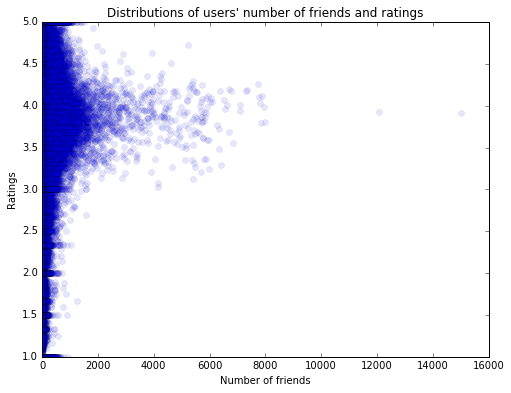

Done


In [7]:
import visualize_friends_stars_users as f_r
import matplotlib.pyplot as plt

friends, ratings = f_r.get_friends_ratings_friends()
plt.figure(figsize=(8, 6))
plt.plot(friends, ratings, 'o', alpha = 0.1)
plt.ylabel("Ratings")
plt.xlabel("Number of friends")
plt.title("Distributions of users' number of friends and ratings")
plt.show()
print "Done"

People who have the most number of friends also tend to rate businesses in the range 3.5-4.5, which is significantly high. Our hypothesis to explain this phenomenon is that users with more friends tend to be more sociable, hence they tend to go hang out with friends, which boost their moods and help them enjoy the atmosphere and services more, and they rate businesses significantly higher.

## 2. Popular check-ins time throughout the week
We wanted to investigate the time during the week when users check in most often in each city. In order to do this, we:
(1) Find cities with the most number of check-ins in all businesses existent in the cities. We hard coded our code so that we will only find the 10 cities with the most number of total check-ins. Function get_popular_time.py/ get_cities() will querry the database and find out these cities.
(2) For each city, we find the average number of check-in in each hours of the week per restaurant (total number of check-ins during an hour in a city / number of businesses in that city). This information is printed out into "../output/check_in_time_by_cities/<city_name>_check_ins.txt"
(3) After data of average check-ins/hour/restaurant in different cities, we generate plots to visualize such information for all cities. The plots are generated in "../output/check_in_time_by_cities/<city_name>_check_ins.png". These plots are not polished, each day in the week are colored differently, and the colors are not well aligned. Therefore, we created a representative plot using Tableu. This figure is stored inside 'plots_to_git/LasVegas_check_ins.png'.

We cannot shot these generated plots in this report, but they show intersting pattern that in each day of the week, there are two peaks time for check-ins, early morning and late at night. Interestingly, the number of check-ins per restaurants are generally lowest at noonish (11AM - 1PM).

In order to call functions to generate plots to find pupolar check-ins times at different cities (all data stored inside "../output/check_in_time_by_cities"), call: 

In [ ]:
# Code to create such files and plots to demonstrate the most popular check-in time during the week for\
# individual cities
import get_popular_time
# create a bunch of files that record the time adn average check-ins time for each city, but we only record\
# 10 cities with the most number of check-ins
get_popular_time.create_popular_time_cities()
get_popular_time.plot_popular_time_all_cities()

## 3. Users' ratings distributions
We looked at all reviews that have been made, and created a histogram of users' ratings. Following the protocol, we querried data in python and created this plot using matplotlib. 

Done executing the command to find users' number of friends and ratings
[4.0, 2.0, 1.0, 3.0, 5.0]
[1032654L, 358550L, 540377L, 517369L, 1704200L]
Done


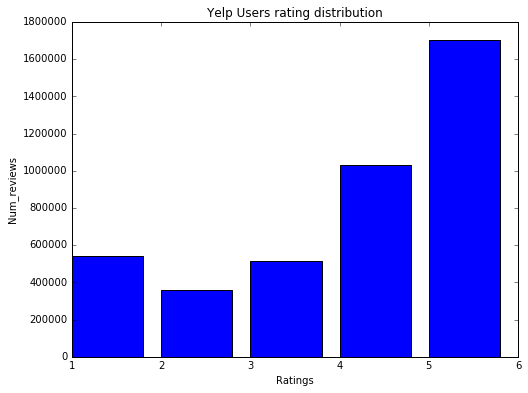

In [10]:
import ratings_distribution as rd
import matplotlib.pyplot as plt
stars, num_stars = rd.get_star_distribution()
print stars
print num_stars
plt.figure(figsize=(8, 6))
plt.bar(stars, num_stars)
plt.ylabel("Num_reviews")
plt.xlabel("Ratings")
plt.title("Yelp Users rating distribution")
plt.show()
print "Done"

Users tend to rate businesses relatively high: 4-5 stars. Apparently, most users tend to give reviews and ratings when they have a really good exprience with the businesses. This results give us insights in choosing a good threshold (used by both recommendation methods) to classify a rating as indicating that users liked or disliked the businesses. We think that since users tend to leave a review when they actually like the business, 4 is a reasonable threshold.

## 4. Businesses's average ratings vs. number of reviews
We want to see any correlation between a business's number of reviews vs. their average ratings. We querried the information from the database, and created graph of such
We have businesses receiving ratings any where from 0 to 5, but the businesses that have the most number of check-ins (mostly very prominent brand) tend to have average ratings:  Star bucks are rated at 3.0. Subway~2.75 McDonald's ~ 2.25. This shows that people’s opinions are different and diverse, and it’s very hard to satisfy all customers. 

The graph is created in Tableau. We created graph for only Las-Vegas because it is the city that has the most number of reviews (total reviews in all businesses). Because graphs in Tableau have to be created manually, we did not generate code to produce this figures for all cities.

The graph can be found at '../plots_to_git/Las_Vegas_ratings_num_reviews.png'


## 5. Users' review count distribution
Because our original model can only be created for users who have reviewed restaurants before, the more reviews the better. We want to see how much-- out of the total population of Yelp users-- can our models serve. We created in Tableau a histogram of number of users who have reviewed a certain number of time. More than 1 million users reviewed 0-200 times, which is the vast majority. 1019 users reviewd more than 1000 times. Therefore, our models can only help recommend a small fraction of Yelp users.

The graph can be found at '../plots_to_git/review_count_distribution.png'

# VII. Work Distribution
Sorry we did not really keep the weekly_status.md updated.

Duy Tran: Research and implementation of Item-based Collaborative Filtering; Create the SQL database and populate it with data from JSON files.  
Drew Zhong: Research and implementation of Original Recommendation Methods; create plots in Tableau.  
Ha Vu: Data cleaning and input preparation for both recommendation system; plotting in Matplotlib. 
Duy Tran, Ha Vu, Drew Zhong all contributed equally to this project.